# Data Processing and Analysis of Dafne performance

**Author**: Francesco Santini, francesco.santini@unibas.ch

**Copyright**: Francesco Santini 2022-2023

**License**: CC-BY (all code, text, data, and images)

## All imports

In [1]:
import os
import re
import glob
import csv
from datetime import datetime
from dateutil.parser import parse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Processing log file

In [2]:
DELETE_NONANON_FILES = False

def find_elements_pattern(string_list, pattern):
    return [ s for s in string_list if re.match(pattern, s) is not None]

### Anonymization

In [3]:
user_map = {}
current_user = 1

def get_anonymized_user(user_str):
    global user_map, current_user
    try:
        return user_map[user_str]
    except KeyError:
        user_map[user_str] = f'{current_user:07d}'
        current_user += 1
        return user_map[user_str]

def anonymize_line(line: str):
    pattern = 'accessed by (\S+)'
    rep = lambda m: f'accessed by {get_anonymized_user(m.group(1))}'
    line = re.sub(pattern, rep, line)
    pattern2 = 'Log message from (\S+)'
    rep2 = lambda m: f'Log message from {get_anonymized_user(m.group(1))}'
    line = re.sub(pattern2, rep2, line)
    pattern3 = r'([0-9]+)_(\S+).model'
    rep3 = lambda m: f'{m.group(1)}_{get_anonymized_user(m.group(2))}.model'
    line = re.sub(pattern3, rep3, line)
    return line
    

def anonymize_file(filename: str):
    global user_map, current_user
    user_map = {}
    current_user = 1
    out_filename = filename[:-3] + 'anon.txt'
    with open(filename, 'r') as input_file:
        with open(out_filename, 'w') as output_file:
            for line in input_file:
                output_file.write(anonymize_line(line))

files = os.listdir()
nonanon_log_files = find_elements_pattern(files, 'log.*(?<!anon)\.txt')
for file in nonanon_log_files:
    anonymize_file(file)
    if DELETE_NONANON_FILES:
        os.unlink(file)
    print('Anonymized', file)


### Read in anonymized file

In [4]:
files = sorted(os.listdir())
anon_log_files = find_elements_pattern(files, 'log.*anon\.txt')
anon_log_file = anon_log_files[-1]
print('Reading from', anon_log_file)

def split_log_line(line: str):
    date_part = line[:27]
    text_part = line[27:].strip()
    date = parse(date_part)
    return (date, text_part)

with open(anon_log_file,'r') as f:
    log_lines = [ split_log_line(line) for line in f ]
    
log_frame = pd.DataFrame(log_lines, columns = ['DateTime', 'Message'])
log_frame = log_frame.set_index('DateTime')


Reading from log_20230102_orig.anon.txt


### Filter dates and messages

In [5]:
date_start = datetime(2021,7,1)

sub_frame = log_frame.loc[date_start:]

In [6]:
# Extract dice scores

def extract_dice(line):
    m = re.search('client dice ([0-9.]+)', line)
    if not m: return None
    return float(m.group(1))

dice_messages_mask = sub_frame['Message'].str.contains('client dice')
dice_messages_frame = sub_frame[dice_messages_mask]
dice_scores = dice_messages_frame['Message'].apply(extract_dice)

def extract_user(line):
    m = re.search('upload_model accessed by ([0-9]+)', line)
    if not m: return None
    return int(m.group(1))

users = dice_messages_frame['Message'].apply(extract_user)

def extract_model(line):
    m = re.search('upload_model accessed by [0-9]+ - ([a-zA-Z]+) -', line)
    if not m: return None
    return m.group(1)

model_type = dice_messages_frame['Message'].apply(extract_model)

users_and_dice = pd.DataFrame({'User': users, 'Model': model_type, 'Dice': dice_scores})
print(users_and_dice)

                            User  Model      Dice
DateTime                                         
2021-07-05 07:46:53.006620    14    Leg       NaN
2021-07-05 08:43:32.036859     6    Leg  0.722032
2021-07-05 12:34:23.546306     9    Leg       NaN
2021-07-05 13:39:20.021036     9    Leg       NaN
2021-07-06 00:03:03.163500     7    Leg  0.061336
...                          ...    ...       ...
2022-12-14 12:53:54.709914     5  Thigh  0.586073
2022-12-20 14:59:34.579354     5  Thigh       NaN
2022-12-21 11:19:24.642261     5  Thigh       NaN
2022-12-21 15:33:15.415373     5  Thigh       NaN
2022-12-22 12:11:15.017470     5  Thigh       NaN

[806 rows x 3 columns]


In [7]:
users_and_dice_notNan = users_and_dice[users_and_dice['Dice'] >= 0]
print(users_and_dice_notNan)
users_and_dice_filt = users_and_dice[users_and_dice['Dice'] > 0.1]
users_and_dice_filt = users_and_dice_filt[users_and_dice_filt['Dice'] < 0.99]
users_and_dice_filt.insert(0, 'date_rank', range(len(users_and_dice_filt)))
users_and_dice_filt.set_index('date_rank', inplace=True)
print(users_and_dice_filt)

                            User  Model      Dice
DateTime                                         
2021-07-05 08:43:32.036859     6    Leg  0.722032
2021-07-06 00:03:03.163500     7    Leg  0.061336
2021-07-06 09:46:34.990739     5    Leg  0.887813
2021-07-06 13:23:26.137980     5    Leg  0.728479
2021-07-06 14:42:50.181395     9    Leg  0.920158
...                          ...    ...       ...
2022-12-06 12:27:59.922697     5  Thigh  0.900576
2022-12-06 14:55:30.356135     5  Thigh  0.821987
2022-12-12 13:28:32.324082     5  Thigh  0.905626
2022-12-12 16:10:19.274829     5  Thigh  0.888514
2022-12-14 12:53:54.709914     5  Thigh  0.586073

[662 rows x 3 columns]
           User  Model      Dice
date_rank                       
0             6    Leg  0.722032
1             5    Leg  0.887813
2             5    Leg  0.728479
3             9    Leg  0.920158
4             7    Leg  0.230225
...         ...    ...       ...
634           5  Thigh  0.900576
635           5  Thigh  0.821

Min: 0.10222602599205255
1st quartile: 0.7384893880683356
Median: 0.8334912165649142
2nd quartile: 0.8884730126911824
Max: 0.9763815896475714


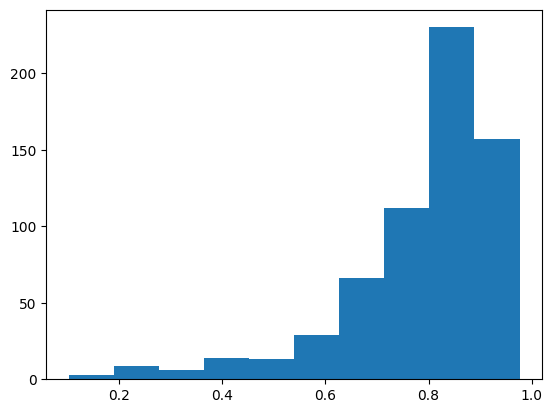

In [8]:
dice_scores_notime = np.array(list(users_and_dice_filt['Dice']))
plt.hist(dice_scores_notime)
print(f'Min: {np.percentile(dice_scores_notime,0)}')
print(f'1st quartile: {np.percentile(dice_scores_notime,25)}')
print(f'Median: {np.percentile(dice_scores_notime,50)}')
print(f'2nd quartile: {np.percentile(dice_scores_notime,75)}')
print(f'Max: {np.percentile(dice_scores_notime,100)}')

In [9]:
def running_average(data, window=30):
    # calculate running average
    average_y = []
    for ind in range(len(data) - window + 1):
        average_y.append(np.mean(data[ind:ind+window]))
    for ind in range(window - 1):
        average_y.insert(0, np.nan)
    return average_y

def extract_model_dataframe(data, model, running_average_window=30):
    data_for_model = data[data['Model'] == model]
    data_for_model.insert(3, 'running_average', running_average(list(data_for_model['Dice']), window=running_average_window))
    return data_for_model

N points: 123
Min: 0.400570694504535
1st quartile: 0.8215588172767245
Median: 0.8770372348978438
2nd quartile: 0.9058231745688079
Max: 0.9763815896475714


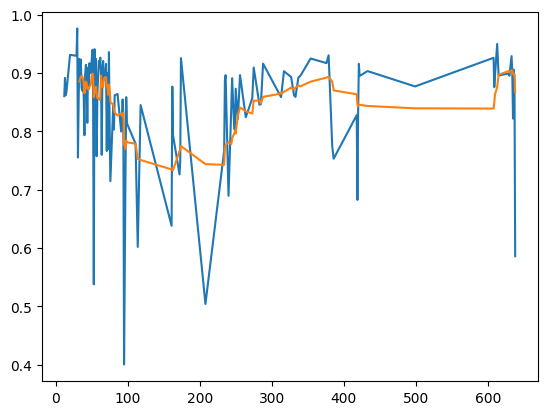

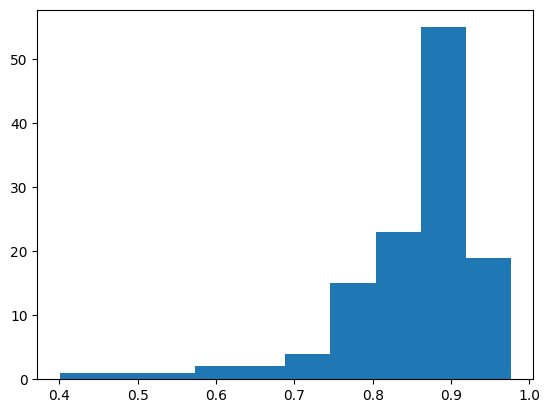

In [10]:
dice_scores_filt_thigh = extract_model_dataframe(users_and_dice_filt, 'Thigh', 10)
plt.plot(dice_scores_filt_thigh[['Dice', 'running_average']])
dice_scores_notime_thigh = np.array(list(dice_scores_filt_thigh['Dice']))
plt.figure()
plt.hist(dice_scores_notime_thigh)
print(f'N points: {len(dice_scores_notime_thigh)}')
print(f'Min: {np.percentile(dice_scores_notime_thigh,0)}')
print(f'1st quartile: {np.percentile(dice_scores_notime_thigh,25)}')
print(f'Median: {np.percentile(dice_scores_notime_thigh,50)}')
print(f'2nd quartile: {np.percentile(dice_scores_notime_thigh,75)}')
print(f'Max: {np.percentile(dice_scores_notime_thigh,100)}')

N points: 516
Min: 0.10222602599205255
1st quartile: 0.7118714681976238
Median: 0.8200816474772294
2nd quartile: 0.8786907200934491
Max: 0.9600523677846019


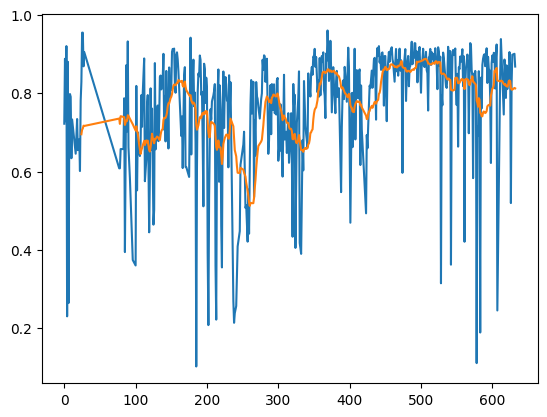

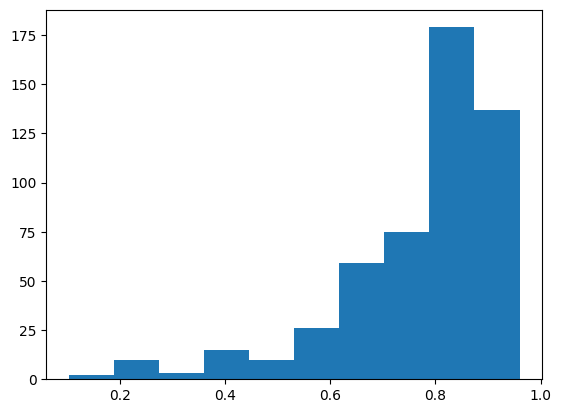

In [11]:
dice_scores_filt_leg = extract_model_dataframe(users_and_dice_filt, 'Leg', 20)
plt.plot(dice_scores_filt_leg[['Dice', 'running_average']])
dice_scores_notime_leg = np.array(list(dice_scores_filt_leg['Dice']))
plt.figure()
plt.hist(dice_scores_notime_leg)
print(f'N points: {len(dice_scores_notime_leg)}')
print(f'Min: {np.percentile(dice_scores_notime_leg,0)}')
print(f'1st quartile: {np.percentile(dice_scores_notime_leg,25)}')
print(f'Median: {np.percentile(dice_scores_notime_leg,50)}')
print(f'2nd quartile: {np.percentile(dice_scores_notime_leg,75)}')
print(f'Max: {np.percentile(dice_scores_notime_leg,100)}')

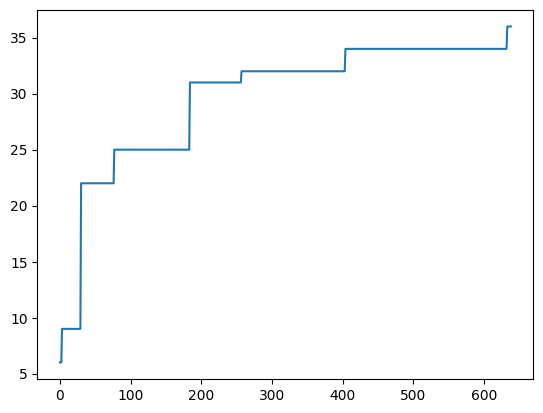

In [12]:
# Get user growth
user_numbers = list(users_and_dice_filt['User'])
max_user_list = []
max_user = 0
for user_number in user_numbers:
    if user_number > max_user:
        max_user = user_number
    max_user_list.append(max_user)

plt.plot(max_user_list)

In [13]:
max_user_list[-1]

36

In [14]:
def plot_dice_and_users(data_frame, user_data):
    # plot the user evolution and dice scores on the same plot
    fig, ax = plt.subplots()
    dice1, = ax.plot(data_frame['Dice'], '.', markersize=1.5, lw=0.3, color='#111111', label='DSC')
    dice2, = ax.plot(data_frame['running_average'], lw = 1.5, color='#E66100', label='DSC (moving average)')
    ax.set_ylabel('Dice Similarity Coefficient (DSC)', color='#E66100')
    ax.set_xlabel('Model generation')
    ax2 = ax.twinx()
    users, = ax2.plot(user_data, color='#5D3A9B', label='Users')
    ax2.set_ylim(0,70)
    ax2.set_ylabel('Number of users', color='#5D3A9B')
    plt.legend(handles=[dice1, dice2, users], loc='lower right')

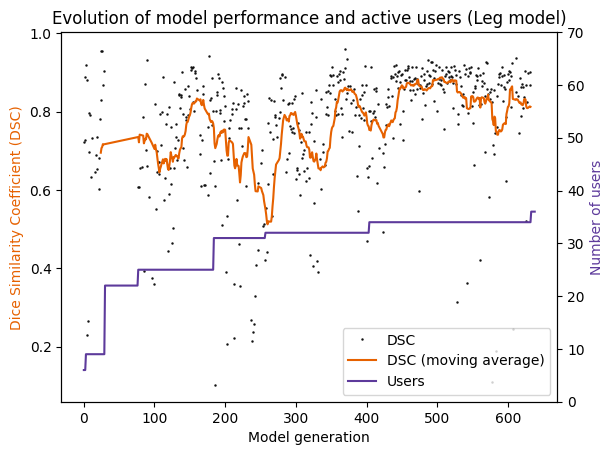

In [15]:
plot_dice_and_users(dice_scores_filt_leg, max_user_list)
plt.title('Evolution of model performance and active users (Leg model)')
plt.savefig('dice_and_users_leg.svg')

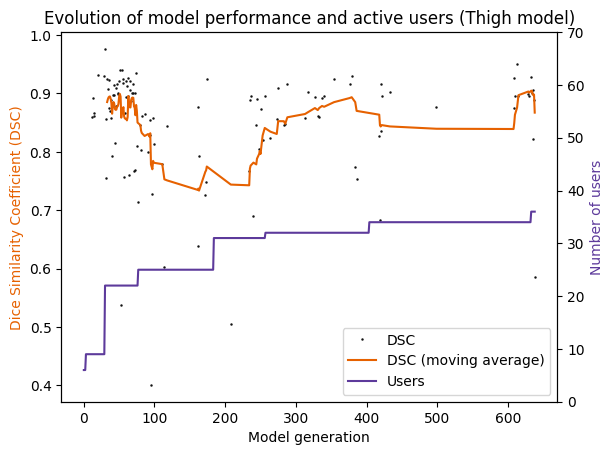

In [16]:
plot_dice_and_users(dice_scores_filt_thigh, max_user_list)
plt.title('Evolution of model performance and active users (Thigh model)')
plt.savefig('dice_and_users_thigh.svg')

# Processing the validation data

The validation data are anonymized data extracted from the local PACS. They were segmented using Dafne and manually refined.
The testing on the various model versions was made using the command (included in Dafne):
```
python /home/francesco/work/workspace/dafne/batch_validate.py --roi <roi_file.p> .
```

## Loading data

In [17]:
#this is the model right before the validation training
training_beginning_model = 1635419523
training_end_model = 1636967897


def load_data_subdirs(base_path):
    subdirs = os.listdir(base_path)
    data_list = []
    for d in subdirs:
        current_subdir = os.path.join(base_path, d)
        txt_file_list = glob.glob(os.path.join(current_subdir, '*.txt'))
        if not txt_file_list:
            continue
        txt_file = txt_file_list[0]
        data_frame = pd.read_csv(txt_file, names=['model_id', 'dice'])
        #data_frame = data_frame.assign(name=d)
        data_frame.insert(0, 'name', d, True)
        #print(data_frame['dice'] - data_frame[data_frame['model_id'] >= training_beginning_model].iloc[0]['dice'])
        data_frame.insert(2, 'relative_dice', data_frame['dice'] - data_frame[data_frame['model_id'] >= training_beginning_model].iloc[0]['dice'])
        # add ranks of models
        data_frame.insert(3, 'model_id_rank', data_frame['model_id'].rank(method='dense'))
        data_list.append(data_frame)
    data_out = pd.concat(data_list)
    return data_out
        
                             
dice_scores_training = load_data_subdirs('validation_results/validation_training')
dice_scores_final_validation = load_data_subdirs('validation_results/final_validation')

def extract_data(data_frame):
    data_frame = data_frame[training_beginning_model <= data_frame['model_id']]
    data_frame = data_frame[data_frame['model_id'] <= training_end_model]
    data_frame['model_id_rank'] -= data_frame['model_id_rank'].min()
    return data_frame
    
dice_scores_training = extract_data(dice_scores_training)
dice_scores_final_validation = extract_data(dice_scores_final_validation)

In [18]:
print('Number of training data:',len(dice_scores_training['name'].unique()))
print('Number of valudation data:',len(dice_scores_final_validation['name'].unique()))

Number of training data: 25
Number of valudation data: 13


In [19]:
initial_dice_dist = dice_scores_training[dice_scores_training['model_id_rank'] == 0]['dice']
final_dice_dist = dice_scores_training[dice_scores_training['model_id_rank'] == dice_scores_training['model_id_rank'].max()]['dice']
print("Training")
print("Initial DSC")
print("1st quartile", initial_dice_dist.quantile(0.25))
print("Median", initial_dice_dist.quantile(0.5))
print("3rd quartile", initial_dice_dist.quantile(0.75))
print("Interquartile range", initial_dice_dist.quantile(0.75) - initial_dice_dist.quantile(0.25))
print("Final DSC")
print("1st quartile", final_dice_dist.quantile(0.25))
print("Median", final_dice_dist.quantile(0.5))
print("3rd quartile", final_dice_dist.quantile(0.75))
print("Interquartile range", final_dice_dist.quantile(0.75) - final_dice_dist.quantile(0.25))

Training
Initial DSC
1st quartile 0.6208468791613646
Median 0.6617590744939363
3rd quartile 0.700608376267342
Interquartile range 0.07976149710597735
Final DSC
1st quartile 0.6869507195585547
Median 0.733489421357802
3rd quartile 0.7738798563197564
Interquartile range 0.08692913676120173


In [20]:
initial_dice_dist = dice_scores_final_validation[dice_scores_final_validation['model_id_rank'] == 0]['dice']
final_dice_dist = dice_scores_final_validation[dice_scores_final_validation['model_id_rank'] == dice_scores_final_validation['model_id_rank'].max()]['dice']
print("Validation")
print("Initial DSC")
print("1st quartile", initial_dice_dist.quantile(0.25))
print("Median", initial_dice_dist.quantile(0.5))
print("3rd quartile", initial_dice_dist.quantile(0.75))
print("Interquartile range", initial_dice_dist.quantile(0.75) - initial_dice_dist.quantile(0.25))
print("Final DSC")
print("1st quartile", final_dice_dist.quantile(0.25))
print("Median", final_dice_dist.quantile(0.5))
print("3rd quartile", final_dice_dist.quantile(0.75))
print("Interquartile range", final_dice_dist.quantile(0.75) - final_dice_dist.quantile(0.25))

Validation
Initial DSC
1st quartile 0.6315224877059067
Median 0.6880203457319318
3rd quartile 0.6910176210113648
Interquartile range 0.05949513330545808
Final DSC
1st quartile 0.6542427162560118
Median 0.711756875709523
3rd quartile 0.7308092881854847
Interquartile range 0.07656657192947292


In [21]:
PLOT_SINGLE_DATALINES = True

def plot_data(data_frame, variable='relative_dice', ylabel='Dice Similarity Coefficient (DSC)\ndifference from baseline'):
    relative_dice_data = data_frame.groupby('name')
    # plot the single lines
    relative_dice_mean = data_frame.groupby('model_id').mean(numeric_only=True)
    if PLOT_SINGLE_DATALINES:
        relative_dice_data.plot(x = 'model_id_rank', y = variable, ax = plt.gca(), linewidth=0.3, color='#c6b5e3')
    else:
        relative_dice_sd = data_frame.groupby('model_id').std(numeric_only=True)
        # plot the standard deviation as area
        sd_plus = (relative_dice_mean+relative_dice_sd).set_index('model_id_rank')[variable]
        sd_minus = (relative_dice_mean-relative_dice_sd).set_index('model_id_rank')[variable]
        plt.gca().fill_between(range(len(relative_dice_mean)), sd_plus, sd_minus, color='#e2daf1')
    relative_dice_mean.plot(x = 'model_id_rank', y = variable, ax = plt.gca(), linewidth=2.5, color='#E66100')
    plt.ylim(-0.15,0.25)
    plt.axhline(color='#777', linewidth=1)
    plt.gca().get_legend().remove()
    plt.xlabel('Model generation')
    plt.ylabel(ylabel)

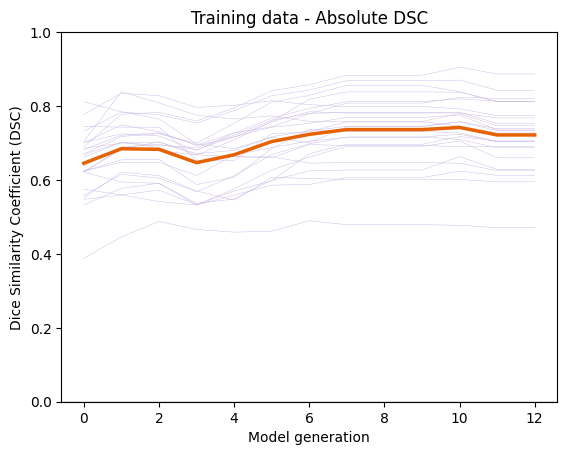

In [22]:
plot_data(dice_scores_training, 'dice', 'Dice Similarity Coefficient (DSC)')
plt.title('Training data - Absolute DSC')
plt.ylim(0,1)
pass

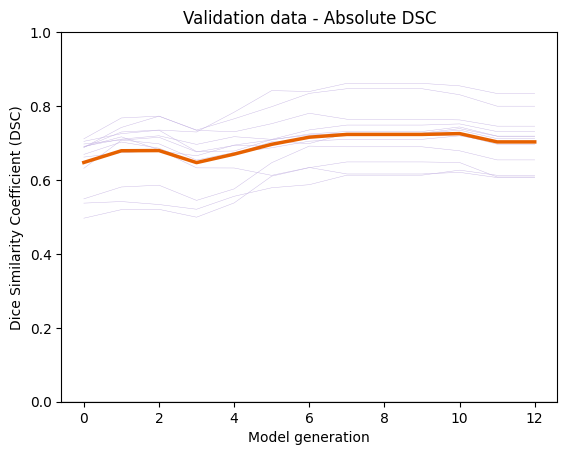

In [23]:
plot_data(dice_scores_final_validation, 'dice', 'Dice Similarity Coefficient (DSC)')
plt.title('Validation data - Absolute DSC')
plt.ylim(0,1)
pass

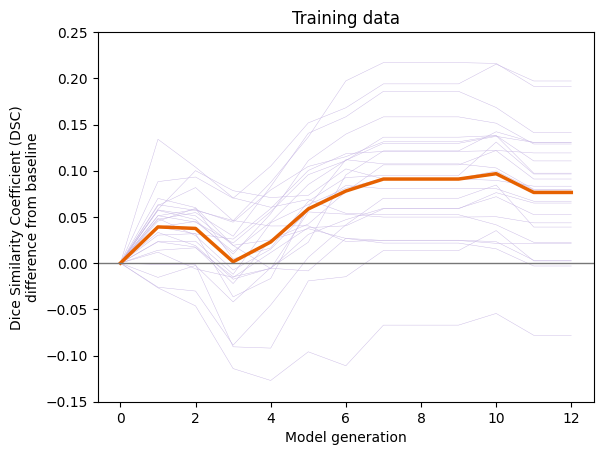

In [24]:
plot_data(dice_scores_training)
plt.title('Training data')
plt.savefig('relative_dice_training.svg')

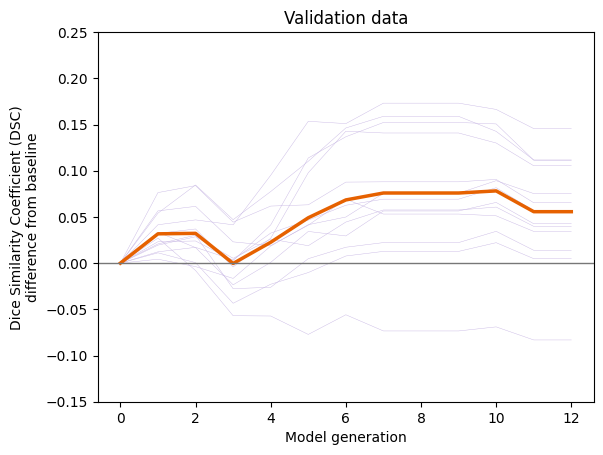

In [25]:
plot_data(dice_scores_final_validation)
plt.title('Validation data')
plt.savefig('relative_dice_validation.svg')

## Statistical evaluation
We use a linear mixed effects model on the relative dice score change.
Every dataset is different, so we are not expecting to see a global improvement at the same rate.
As the first point is forcibly set to 0 because of the calculation of the relative DSC, the intercept of the model is constrained to 0, thus resulting in the formula:
<center>$relative\_score \sim 0 + model\_version + (model\_version|dataset)$</center>
As the DSC is limited between 0 and 1, its increase is very small, which results in convergence warnings by the REML fitter as it cannot correctly calculate the variance. For this reason, the fitting is performed on a rescaled (by 1000) variable.

In [26]:
# linear mixed model with zero intercept and random slope depending on the dataset
def fit_lmm(data_frame):
    print('Important! We are using the relative dice score *1000 to avoid convergence warnings! Rescale the results!')
    data_frame['relative_dice_times_1000'] = data_frame['relative_dice']*1000
    md = smf.mixedlm('relative_dice_times_1000 ~ 0 + model_id_rank', data_frame, groups=data_frame['name'], re_formula="~0 + model_id_rank")
    return md.fit()

In [27]:
fit_lmm(dice_scores_training).summary()

Important! We are using the relative dice score *1000 to avoid convergence warnings! Rescale the results!


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:            MixedLM Dependent Variable: relative_dice_times_1000
No. Observations: 325     Method:             REML                    
No. Groups:       25      Scale:              1115.0666               
Min. group size:  13      Log-Likelihood:     -1641.2980              
Max. group size:  13      Converged:          Yes                     
Mean group size:  13.0                                                
------------------------------------------------------------------------
                     Coef.    Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------------
model_id_rank         9.050      1.388   6.522   0.000    6.330   11.770
model_id_rank Var    46.427      0.433                                  
======================================================================

"""

In [28]:
fit_lmm(dice_scores_final_validation).summary()

Important! We are using the relative dice score *1000 to avoid convergence warnings! Rescale the results!


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:            MixedLM Dependent Variable: relative_dice_times_1000
No. Observations: 169     Method:             REML                    
No. Groups:       13      Scale:              786.9001                
Min. group size:  13      Log-Likelihood:     -825.2850               
Max. group size:  13      Converged:          Yes                     
Mean group size:  13.0                                                
------------------------------------------------------------------------
                     Coef.    Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------------
model_id_rank         7.268      1.951   3.726   0.000    3.444   11.092
model_id_rank Var    48.263      0.747                                  
======================================================================

"""

### Simple linear model

As a simpler approach, we also present a linear fit, which gives the same point estimate but lower standard deviation of the slope. However, this does not take into account the correlation between the observations of the same dataset.

In [29]:
def fit_lm(data_frame):
    model = sm.OLS(data_frame['relative_dice'], data_frame['model_id_rank']).fit()
    return model

In [30]:
model_training = fit_lm(dice_scores_training)
model_training.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          relative_dice   R-squared (uncentered):                   0.551
Model:                            OLS   Adj. R-squared (uncentered):              0.549
Method:                 Least Squares   F-statistic:                              397.2
Date:                Thu, 20 Mar 2025   Prob (F-statistic):                    2.98e-58
Time:                        14:39:05   Log-Likelihood:                          465.38
No. Observations:                 325   AIC:                                     -928.8
Df Residuals:                     324   BIC:                                     -925.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
model_id_rank     0.0090      0.000     19.931      0.000       0.008       0.010
==============================================================================
Omnibus:                       13.745   Durbin-Watson:                   0.305
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.131
Skew:                          -0.373   Prob(JB):                     0.000191
Kurtosis:                       3.841   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
model_validation = fit_lm(dice_scores_final_validation)
model_validation.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          relative_dice   R-squared (uncentered):                   0.467
Model:                            OLS   Adj. R-squared (uncentered):              0.464
Method:                 Least Squares   F-statistic:                              147.4
Date:                Thu, 20 Mar 2025   Prob (F-statistic):                    9.32e-25
Time:                        14:39:05   Log-Likelihood:                          250.80
No. Observations:                 169   AIC:                                     -499.6
Df Residuals:                     168   BIC:                                     -496.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
model_id_rank     0.0073      0.001     12.142      0.000       0.006       0.008
==============================================================================
Omnibus:                        7.334   Durbin-Watson:                   0.270
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                8.150
Skew:                          -0.345   Prob(JB):                       0.0170
Kurtosis:                       3.825   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Example images

These images are generated with the following commands included in the dafne-models repository on the data included in the `image_data` folder.

* 1610001000: timestamp of the initial trained model
* 1669385545: timestamp corresponding to november 25, 2022 (latest available leg model at the time of writing)

## Ground truth (manual) segmentation

The ground truth for the example images is stored as Dafne ROI files and as Numpy outputs as `XX_manual_rois.(p|npz)` files.

The ground truth overlay is generated with
```
./plot_groundtruth.py <npz_file> # this generates a groundtruth.png file with the appropriate colors and transparency
convert <segmented png> groundtruth.png -flatten <segmented png>_with_truth.png
```

`testing/visualize_segmentation.py --classification Leg image_data/pd_example.npz 1610001000`

![pd_1610001000](image_data/segmented_pd_example_1610001000.png)
![pd_1610001000_truth](image_data/segmented_pd_example_1610001000_with_truth.png)

`testing/visualize_segmentation.py --classification Leg image_data/pd_example.npz 1669385545`

![pd_1669385545](image_data/segmented_pd_example_1669385545.png)
![pd_1669385545_with_truth](image_data/segmented_pd_example_1669385545_with_truth.png)

`testing/visualize_segmentation.py --classification Leg image_data/t1_example.npz 1610001000`

![t1_1610001000](image_data/segmented_t1_example_1610001000.png)
![t1_1610001000_with_truth](image_data/segmented_t1_example_1610001000_with_truth.png)

`testing/visualize_segmentation.py --classification Leg image_data/t1_example.npz 1669385545`

![t1_1669385545](image_data/segmented_t1_example_1669385545.png)
![t1_1669385545_with_truth](image_data/segmented_t1_example_1669385545_with_truth.png)

`testing/visualize_segmentation.py --classification Leg image_data/t1_example_2.npz 1610001000`

![t1_2_1610001000](image_data/segmented_t1_example_2_1610001000.png)
![t1_2_1610001000_with_truth](image_data/segmented_t1_example_2_1610001000_with_truth.png)

`testing/visualize_segmentation.py --classification Leg image_data/t1_example_2.npz 1669385545`

![t1_2_1669385545](image_data/segmented_t1_example_2_1669385545.png)
![t1_2_1669385545_with_truth](image_data/segmented_t1_example_2_1669385545_with_truth.png)